# Exploratory Data Analysis

En este estudio, se realizará un análisis exploratorio de datos (EDA) utilizando el conjunto de datos combined_data.csv, el cual contiene un total de 83,448 ejemplos de correos electrónicos, cada uno etiquetado como 'spam' (1) o 'no spam' (0). Este análisis es un paso crucial para comprender la estructura y las características de los datos antes de proceder con cualquier modelado o análisis estadístico más complejo.

In [76]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from textblob import Word
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import plotly.express as px

from nltk.tokenize import word_tokenize
import re
from collections import Counter

import matplotlib.pyplot as plt

In [77]:
data = pd.read_csv('data/combined_data.csv')

data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


## Revisar duplicados

In [78]:
# Number of duplicate rows
data.duplicated().sum()

0

En este caso como se puede observar no existen dublicados en nuestros datos

# Check datatypes and missing values

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


Como se ha mencionado anteriormente existen 83,448 registros

## Analyze class imbalance

In [80]:
def check_class_imbalance(data, column_name):
    # Calculate the frequency of each class
    class_counts = data[column_name].value_counts()
    # Calculate the percentage of each class
    class_percentage = data[column_name].value_counts(normalize=True) * 100
    # Create a DataFrame to display counts and percentages
    imbalance_df = pd.DataFrame({'Counts': class_counts, 'Percentage': class_percentage})
    return imbalance_df

In [81]:
check_class_imbalance(data, 'label')

,Counts,Percentage
label,,
1,43910,52.619595
0,39538,47.380405


Se puede observar que hay un desequilibrio de clases en nuestro conjunto de datos, con los de spam teniendo 4.372 etiquetas más que la clase de correos no spam. Sin embargo, es demasiado pequeño el desequilibrio en funcion del tamaño de los datos como para tomar medidas, realmente estan equilibrados.

In [83]:
data["text"].values[:3]

array(['ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadron heft quell yoghurt bunkmate divert afterimage',
       "wulvob get your medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt have you ever stopped to wonder how much an average man pays for his mediecines ap painkillers drugs to improve the quality of life weight reducing tablets and many more escapenumber what's worse the same mediucine costs a lot more if it is branded rfwur are you intrested so http dmvrwm remunerativ net dfuaeirxygiq visit our website escapenumber",
       " computer conn

In [84]:
# Cargar contracciones desde un CSV y convertirlo a un diccionario
contractions_df = pd.read_csv("data/Contractions.csv", sep=";")
contractions_dict = dict(zip(contractions_df['contraction'], contractions_df['expanded']))

# Descargar stopwords y wordnet
nltk.download("stopwords")
nltk.download("wordnet")

# Cargar stopwords
stop_words = stopwords.words("english")

# Crear lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgeperalta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jorgeperalta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess_text(text, contractions_dict, stop_words, lemmatizer):
    # Asegurarse de que el texto sea una cadena
    text = str(text)
    # Expandir contracciones
    text = ' '.join([contractions_dict.get(word.lower(), word) for word in text.split()])
    # Remover caracteres no alfabéticos y convertir a minúsculas
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Remover stopwords y lematizar
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

# Preprocesar texto
data["text"] = data["text"].apply(lambda x: preprocess_text(x, contractions_dict, stop_words, lemmatizer))
print(data["text"].values[:3])

## Frecuencia de las palabras

In [44]:
def get_word_counts(data, column_name):
    # Initialize a Counter object to keep track of word counts
    word_counts = Counter()
    # Iterate over each entry in the specified column
    for text in data[column_name]:
        # Split text into words and update the counter
        word_counts.update(text.split())
    # Convert the counter object to a DataFrame for easier viewing/manipulation
    words_count_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    return words_count_df.sort_values(by='Count', ascending=False)

# Get the number of occurrences of every word in the dataset
words_count_data = get_word_counts(data, "text")
words_count_data

,Word,Count
27,escapenumber,1148051
179,escapelong,227296
65,http,91520
75,com,69818
327,r,62081
...,...,...
154178,coverart,1
154177,ofhis,1
154175,banality,1
154174,passional,1


Como se puede ver, algunas palabras se repiten frecuentemente pero no aportan significado, como escapenumber o escapelong. Por otra parte, términos como http o com sugieren que los correos probablemente incluyen enlaces web.

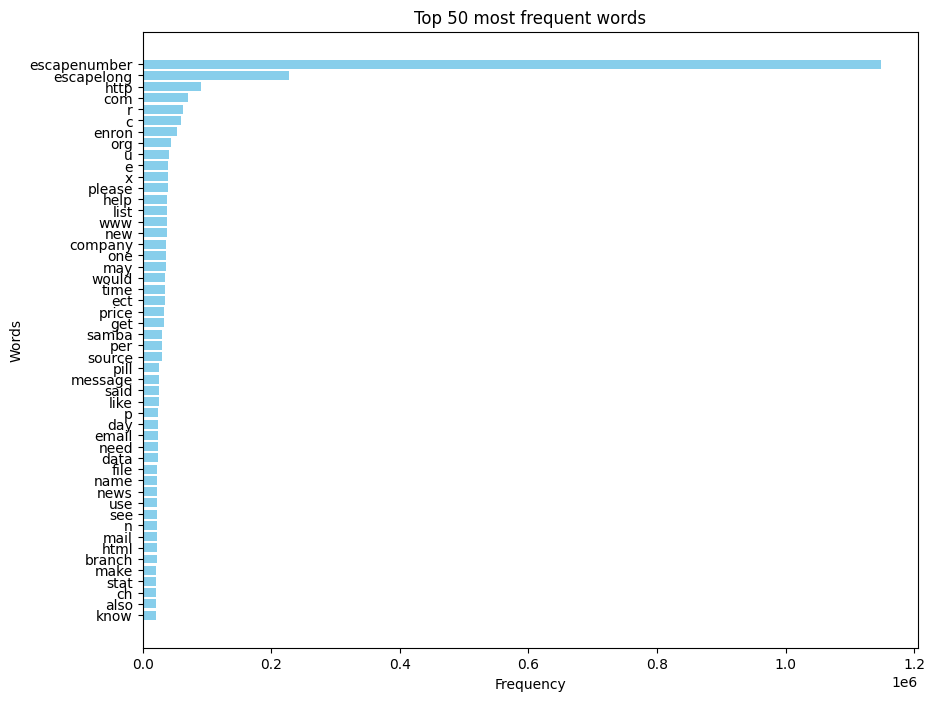

In [51]:
def plot_top_n_words_frequency(data, word_column, count_column, top_n):
    # Sort the data by frequency (count) in descending order
    sorted_data = data.sort_values(by=count_column, ascending=False)
    # Slice the top N words
    top_words = sorted_data.head(top_n)
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(top_words[word_column], top_words[count_column], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {top_n} most frequent words')
    plt.gca().invert_yaxis()  # To display the highest frequency at the top
    plt.show()

# Plot the frequency distribution of the 50 most common words in the dataset
plot_top_n_words_frequency(words_count_data, "Word", "Count", 50)

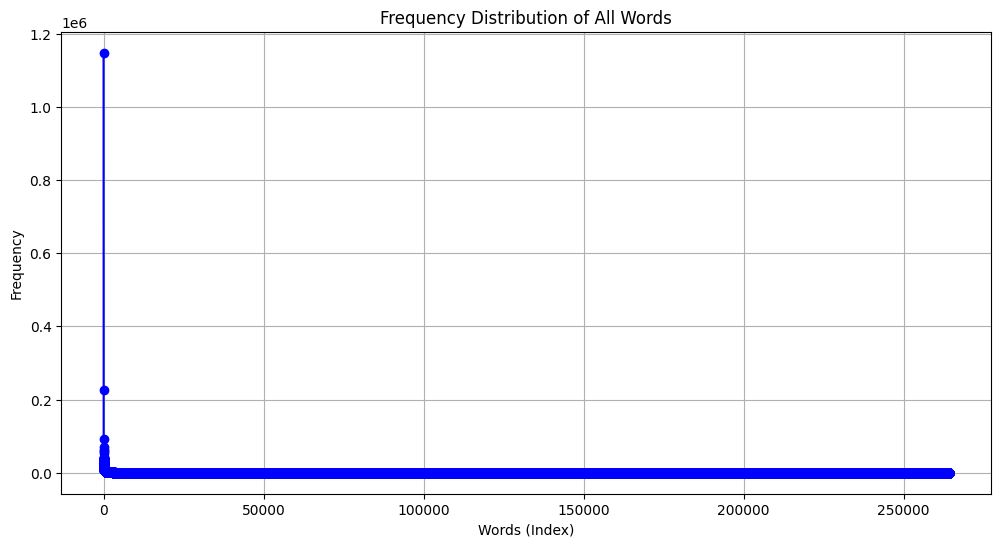

In [55]:
def plot_word_frequency_distribution(data, count_column):
    # Assuming 'data' has been sorted or needs no sorting
    plt.figure(figsize=(12, 6))
    plt.plot(data[count_column].values, linestyle='-', marker='o', color='b')
    plt.title('Frequency Distribution of All Words')
    plt.xlabel('Words (Index)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the frequency distribution of every word in the dataset
plot_word_frequency_distribution(words_count_data, "Count")

In [57]:
# Print the number of different words in the dataset
print(f"Number of different words in the dataset: {len(words_count_data)}")
# Create a table with the number of words with less than 10, 5, 3 and 2 occurrences
word_counts_aux = pd.DataFrame({"Count": [10, 5, 3, 2]})
word_counts_aux["number_of_words"] = (
    word_counts_aux["Count"]
    .apply(lambda x: len(words_count_data[words_count_data["Count"] < x]))
)
word_counts_aux

Number of different words in the dataset: 264164


,Count,number_of_words
0,10,217609
1,5,190958
2,3,163422
3,2,131298


In [61]:
def filter_words_by_frequency(text, word_freq):
    # Split text into words
    words = text.split()
    # Filter words based on frequency in the word_freq dictionary
    filtered_words = [word for word in words if word_freq.get(word, 0) >= 5]  # Example: keep words with frequency >= 5
    # Join words back into a string
    return ' '.join(filtered_words)

# Create a dictionary with the words and their frequency for faster access
word_freq = dict(zip(words_count_data["Word"], words_count_data["Count"]))

# Apply the filter_words_by_frequency function to the "headline" column
data["text"] = data["text"].apply(filter_words_by_frequency, args=(word_freq,))

In [62]:
# Get the length of every headline
data["length"] = data["text"].apply(lambda x: len(x.split()))
data.head()

,label,text,length
0,1,ounce feather bowl hummingbird opec moment ala...,20
1,1,get medircations online viagra escapenumber es...,71
2,0,computer connection cnn com wednesday escapenu...,275
3,1,university degree obtain prosperous future mon...,53
4,0,thanks answer guy know checked rsync manual wo...,148


In [68]:
# Get the headlines with length 2 or less
short_headlines = data[data["text"].apply(lambda x: len(x.split()) <= 2)]["text"].unique()
print(f'There are {len(short_headlines)} headlines with length 5 or less.')
# Drop them
data = data[~data["text"].isin(short_headlines)]

There are 128 headlines with length 5 or less.


## Word Cloud

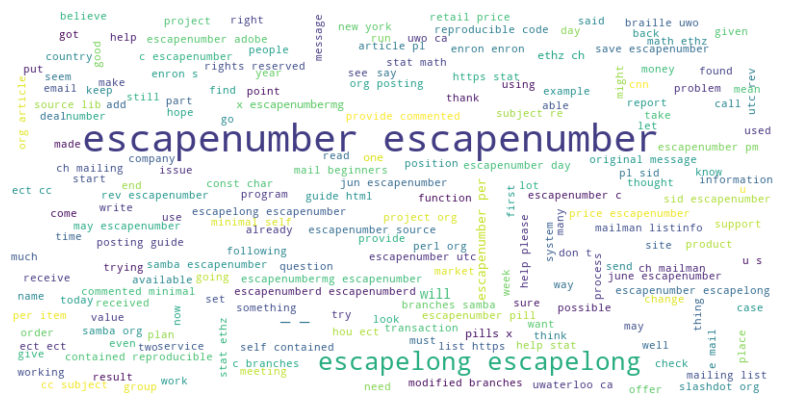

In [72]:
def plot_wordcloud(data, column):
    # Join all the text in the column into a single string
    text = ' '.join(data[column].dropna())
    # Create the word cloud object, set the size and background color
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.show()

plot_wordcloud(data, "text")

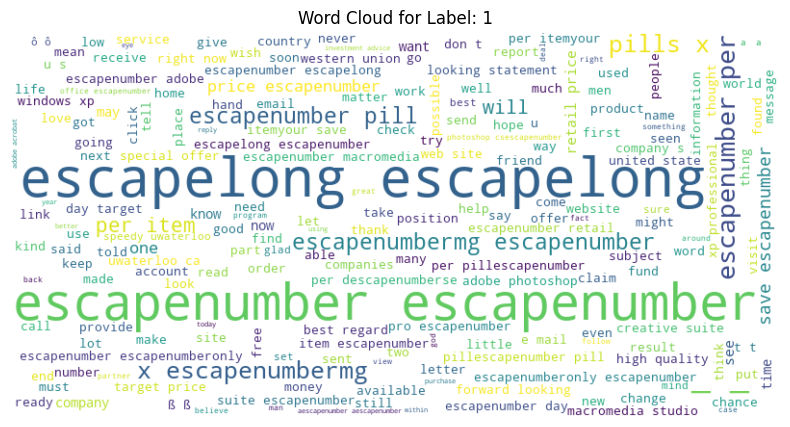

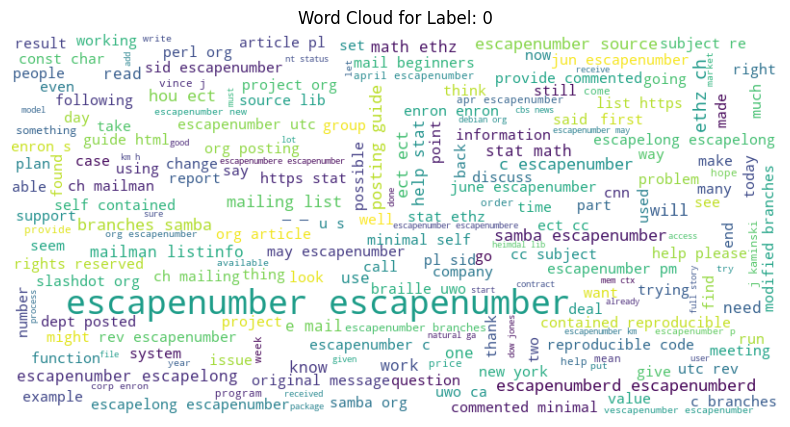

In [75]:
def plot_wordcloud_by_label(data, text_column, label_column):
    # Get unique labels
    labels = data[label_column].unique()
    
    # Create a word cloud for each label
    for label in labels:
        # Filter the data for the current label
        subset = data[data[label_column] == label]
        # Join all text for the current label into a single string
        text = ' '.join(subset[text_column].dropna())
        # Create the word cloud object
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        # Plot settings
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Label: {label}')
        plt.axis('off')
        plt.show()

plot_wordcloud_by_label(data, "text", "label")

Como se puede observar, las palabras más usadas del conjunto no aportan mucha información. Son palabras sin sentido. Sin embargo, en el caso del spam, se introducen algunos caracteres raros o se mencionan palabras como 'website' o 'company', términos que podrían tener sentido en el contexto de spam. Otras palabras que se mencionan pero sin tanta frecuencia son, 'pills' o 'product'. Estas palabras suelen ser comunes en correos de spam.